# **LIBRARY IMPORTS**



In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
from google.colab import drive
from pathlib import Path
from typing import Tuple, Dict, List, Optional

import cv2
from PIL import Image
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import timm
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import logging
import warnings
import time
from collections import defaultdict
import random

warnings.filterwarnings("ignore")

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)


# **DATA LOADING AND PREPARATION**

## Dataset Loading and Validation

In [3]:
class DatasetLoader:
    """
    Handles dataset loading and validation for the crop Classification project.

    Attributes:
        drive_path (str): Path to the Google Drive folder
        dataset_name (str): Name of the dataset zip file
        extract_path (str): Path where dataset will be extracted
    """

    def __init__(self):
        # Initialize paths
        self.drive_path = '/content/drive/MyDrive/Disease Identification'
        self.dataset_name = 'Dataset.zip'
        self.extract_base = '/content/dataset'

        # Full paths after extraction
        self.dataset_root = os.path.join(self.extract_base, 'Dataset')
        self.paths = {
            'zip_file': os.path.join(self.drive_path, self.dataset_name),
            'train_dir': os.path.join(self.dataset_root, 'Train'),
            'test_dir': os.path.join(self.dataset_root, 'Test'),
            'train_labels': os.path.join(self.dataset_root, 'train_labels.csv'),
            'test_labels': os.path.join(self.dataset_root, 'test_labels.csv')
        }

    def mount_drive(self) -> bool:
        """Mount Google Drive."""
        try:
            logger.info("Mounting Google Drive...")
            drive.mount('/content/drive', force_remount=True)
            return True
        except Exception as e:
            logger.error(f"Failed to mount drive: {str(e)}")
            return False

    def extract_dataset(self) -> bool:
        """Extract dataset from zip file."""
        try:
            if not os.path.exists(self.paths['zip_file']):
                raise FileNotFoundError(f"Dataset zip not found at {self.paths['zip_file']}")

            logger.info("Extracting dataset...")
            with zipfile.ZipFile(self.paths['zip_file'], 'r') as zip_ref:
                zip_ref.extractall(self.extract_base)
            logger.info("Dataset extracted successfully")
            return True
        except Exception as e:
            logger.error(f"Failed to extract dataset: {str(e)}")
            return False

    def validate_dataset(self) -> Dict[str, Dict[str, any]]:
        """
        Validate the extracted dataset structure and contents.

        Returns:
            Dictionary containing validation results for each component
        """
        validation = {
            'directories': {
                'train': {'exists': False, 'count': 0},
                'test': {'exists': False, 'count': 0}
            },
            'labels': {
                'train': {'exists': False, 'size': 0},
                'test': {'exists': False, 'size': 0}
            }
        }

        # Validate directories and count images
        if os.path.exists(self.paths['train_dir']):
            validation['directories']['train']['exists'] = True
            validation['directories']['train']['count'] = len([
                f for f in os.listdir(self.paths['train_dir'])
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])

        if os.path.exists(self.paths['test_dir']):
            validation['directories']['test']['exists'] = True
            validation['directories']['test']['count'] = len([
                f for f in os.listdir(self.paths['test_dir'])
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])

        # Validate label files
        if os.path.exists(self.paths['train_labels']):
            validation['labels']['train']['exists'] = True
            validation['labels']['train']['size'] = os.path.getsize(self.paths['train_labels'])

        if os.path.exists(self.paths['test_labels']):
            validation['labels']['test']['exists'] = True
            validation['labels']['test']['size'] = os.path.getsize(self.paths['test_labels'])

        return validation

    def print_validation_results(self, validation: Dict) -> None:
        """Print formatted validation results."""
        print("\nDataset Validation Results:")
        print("-" * 50)

        print("\nDirectories:")
        print(f"Training Directory: {'✓' if validation['directories']['train']['exists'] else '✗'}")
        print(f"├── Image Count: {validation['directories']['train']['count']}")
        print(f"Test Directory: {'✓' if validation['directories']['test']['exists'] else '✗'}")
        print(f"├── Image Count: {validation['directories']['test']['count']}")

        print("\nLabel Files:")
        print(f"Training Labels: {'✓' if validation['labels']['train']['exists'] else '✗'}")
        print(f"Test Labels: {'✓' if validation['labels']['test']['exists'] else '✗'}")

    def setup(self) -> Tuple[bool, Dict]:
        """
        Complete dataset setup process.

        Returns:
            Tuple containing success status and validation results
        """
        # Mount drive
        if not self.mount_drive():
            return False, {}

        # Extract dataset
        if not self.extract_dataset():
            return False, {}

        # Validate dataset
        validation_results = self.validate_dataset()
        self.print_validation_results(validation_results)

        # Check if all components are present
        setup_success = (
            validation_results['directories']['train']['exists'] and
            validation_results['directories']['test']['exists'] and
            validation_results['labels']['train']['exists'] and
            validation_results['labels']['test']['exists'] and
            validation_results['directories']['train']['count'] > 0 and
            validation_results['directories']['test']['count'] > 0
        )

        if not setup_success:
            logger.warning("Dataset setup incomplete - some components are missing")
        else:
            logger.info("Dataset setup completed successfully")

        return setup_success, validation_results

# Execute the setup
loader = DatasetLoader()
success, validation = loader.setup()

# If successful, make paths easily accessible
if success:
    TRAIN_DIR = loader.paths['train_dir']
    TEST_DIR = loader.paths['test_dir']
    TRAIN_LABELS = loader.paths['train_labels']
    TEST_LABELS = loader.paths['test_labels']
    print("\nPaths are now ready for use in subsequent steps")
else:
    print("\nWARNING: Setup incomplete - please check the validation results above")

Mounted at /content/drive

Dataset Validation Results:
--------------------------------------------------

Directories:
Training Directory: ✓
├── Image Count: 3688
Test Directory: ✓
├── Image Count: 928

Label Files:
Training Labels: ✓
Test Labels: ✓

Paths are now ready for use in subsequent steps


## Image Processing

In [4]:
class ImageProcessor:
    """Handles image validation and preprocessing."""

    @staticmethod
    def validate_and_resize_images(directory: str, target_size: Tuple[int, int] = (224, 224)) -> Dict:
        stats = {'total': 0, 'processed': 0, 'errors': 0}

        # Look for images with different extensions
        extensions = ('*.jpg', '*.JPG')

        # Collect all image paths first
        all_image_paths = []
        for ext in extensions:
            all_image_paths.extend(Path(directory).rglob(ext))

        # Update total count
        stats['total'] = len(all_image_paths)

        # Process images with a progress bar for the total count
        for img_path in tqdm(all_image_paths, desc=f"Processing images in {Path(directory).name}"):
            try:
                with Image.open(img_path) as img:
                    if img.size != target_size:
                        img = img.convert('RGB')
                        img = img.resize(target_size, Image.LANCZOS)
                        img.save(img_path, quality=95, format='JPEG')
                        stats['processed'] += 1
            except Exception as e:
                stats['errors'] += 1
                logger.error(f"Error processing {img_path}: {str(e)}")

        print(f"\nDirectory {Path(directory).name}:")
        print(f"Total images: {stats['total']}")
        print(f"Processed: {stats['processed']}")
        print(f"Errors: {stats['errors']}")

        return stats

ImageProcessor.validate_and_resize_images(TRAIN_DIR)
ImageProcessor.validate_and_resize_images(TEST_DIR)

Processing images in Train:   0%|          | 0/3688 [00:00<?, ?it/s]


Directory Train:
Total images: 3688
Processed: 3688
Errors: 0


Processing images in Test:   0%|          | 0/928 [00:00<?, ?it/s]


Directory Test:
Total images: 928
Processed: 928
Errors: 0


{'total': 928, 'processed': 928, 'errors': 0}

## Label Processing



train_labels Label Analysis:
Number of unique classes: 21
Label range: 0 - 20
Missing classes: set()

Class distribution:
Min samples per class: 168
Max samples per class: 176
Mean samples per class: 175.62


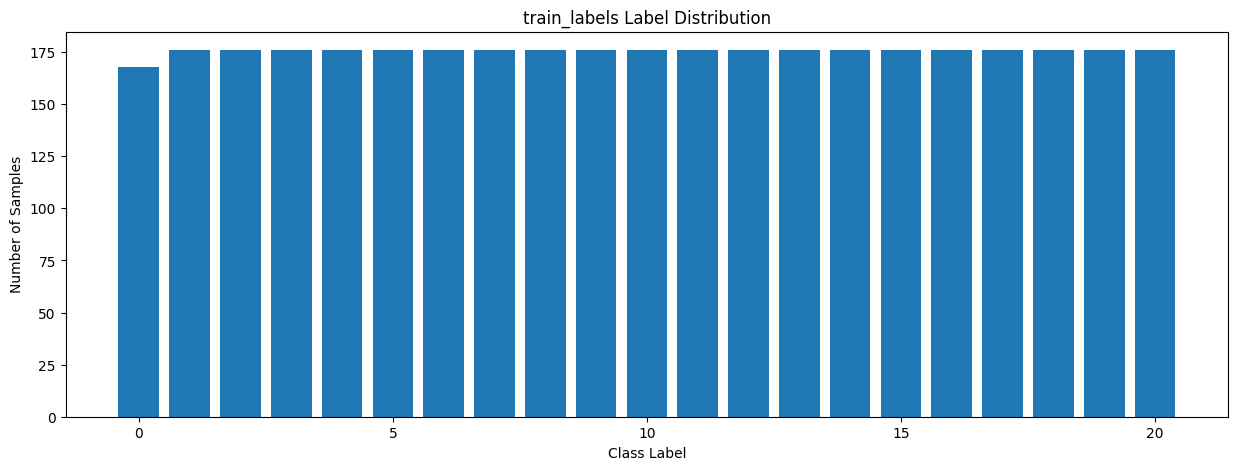



test_labels Label Analysis:
Number of unique classes: 21
Label range: 0 - 20
Missing classes: set()

Class distribution:
Min samples per class: 44
Max samples per class: 48
Mean samples per class: 44.19


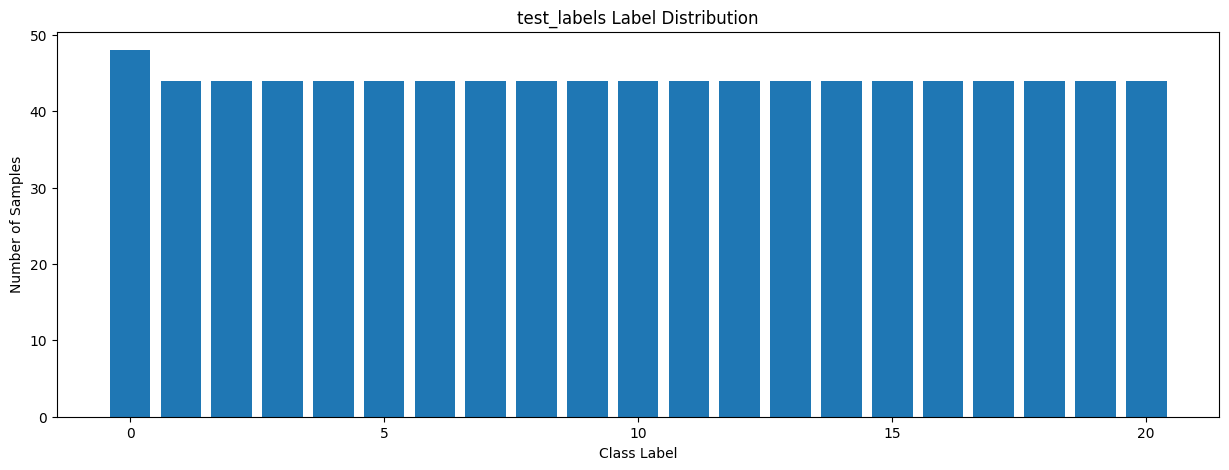

In [9]:
class LabelAnalyzer:
    """Analyzes and verifies label distribution in datasets."""

    @staticmethod
    def analyze_labels(dataframe: pd.DataFrame, name: str, expected_classes: int = 21) -> None:
        """
        Analyze label distribution in dataset.

        Args:
            dataframe: DataFrame containing labels
            name: Name of the dataset for reporting
            expected_classes: Expected number of unique classes
        """
        unique_labels = dataframe['disease'].unique()
        label_counts = dataframe['disease'].value_counts().sort_index()

        print(f"\n{name} Label Analysis:")
        print(f"Number of unique classes: {len(unique_labels)}")
        print(f"Label range: {min(unique_labels)} - {max(unique_labels)}")
        print(f"Missing classes: {set(range(expected_classes)) - set(unique_labels)}")

        print("\nClass distribution:")
        print(f"Min samples per class: {label_counts.min()}")
        print(f"Max samples per class: {label_counts.max()}")
        print(f"Mean samples per class: {label_counts.mean():.2f}")

        # Plot label distribution
        plt.figure(figsize=(15, 5))
        plt.bar(label_counts.index, label_counts.values)
        plt.title(f'{name} Label Distribution')
        plt.xlabel('Class Label')
        plt.ylabel('Number of Samples')
        plt.show()

# Label Processing with Verification
class LabelProcessor:
    """Handles label validation and processing."""

    @staticmethod
    def process_labels(csv_path: str, img_dir: str, expected_classes: int = 20) -> pd.DataFrame:
        """
        Process and validate labels with class verification.

        Args:
            csv_path: Path to labels CSV
            img_dir: Directory containing images
            expected_classes: Expected number of unique classes
        """
        df = pd.read_csv(csv_path)

        # Verify label range
        if not all(0 <= label < expected_classes for label in df['disease']):
            invalid_labels = df[~df['disease'].between(0, expected_classes-1)]
            print(f"\nWARNING: Found invalid labels in {Path(csv_path).name}:")
            # print(invalid_labels[['file_path', 'crop', 'disease', 'composition']])

        # Process paths and validate existence
        df['full_path'] = df['file_path'].apply(
            lambda x: os.path.join(img_dir, Path(x).name)
        )
        valid_files = df['full_path'].apply(os.path.exists)
        valid_df = df[valid_files].copy()

        # Analyze label distribution
        LabelAnalyzer.analyze_labels(valid_df, Path(csv_path).stem)

        return valid_df

# Reprocess labels with verification
train_df = LabelProcessor.process_labels(TRAIN_LABELS, TRAIN_DIR)
test_df = LabelProcessor.process_labels(TEST_LABELS, TEST_DIR)

## Dataset Class

In [ ]:
class CropClassificationDataset(Dataset):
    """Custom Dataset for crop image classification."""

    def __init__(self, data: pd.DataFrame, transform: Optional[transforms.Compose] = None, shuffle: bool = True):
        """
        Initialize dataset with optional shuffling.

        Args:
            data: DataFrame containing image paths and labels
            transform: Optional transforms to be applied
            shuffle: Whether to shuffle the dataset indices
        """
        self.data = data.copy()  # Create a copy to avoid modifying original
        self.transform = transform

        self.validate_labels()

    def validate_labels(self) -> None:
        """Validate label distribution in dataset."""
        labels = self.data['Label'].values
        unique_labels, counts = np.unique(labels, return_counts=True)

        print(f"\nDataset Label Validation:")
        print(f"Number of samples: {len(labels)}")
        print(f"Label range: {labels.min()} - {labels.max()}")
        print(f"Number of unique classes: {len(unique_labels)}")
        print(f"Samples per class - Min: {counts.min()}, Max: {counts.max()}, Mean: {counts.mean():.2f}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.data.iloc[idx]['full_path']
        label = self.data.iloc[idx]['Label']

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

## Two Stage Classifier

In [10]:
# Required imports
import os
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Tuple, Dict, List, Optional, Union

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [21]:
class CropClassificationDataset(Dataset):
    """Custom Dataset for crop classification with dual-mode support."""

    def __init__(
        self,
        data: pd.DataFrame,
        transform: Optional[transforms.Compose] = None,
        mode: str = "classifier"  # "classifier" or "projection"
    ):
        """
        Initialize dataset with optional mode selection.

        Args:
            data: DataFrame containing image paths and labels
            transform: Optional transforms to be applied
            mode: Whether to return data for classifier or projection head training
        """
        self.data = data.copy()
        self.transform = transform
        self.mode = mode
        self.validate_labels()

    def validate_labels(self) -> None:
        """Validate label distribution in dataset."""
        labels = self.data['disease'].values
        unique_labels, counts = np.unique(labels, return_counts=True)

        print(f"\nDataset Label Validation [{self.mode}]:")
        print(f"Number of samples: {len(labels)}")
        print(f"Label range: {labels.min()} - {labels.max()}")
        print(f"Number of unique classes: {len(unique_labels)}")
        print(f"Samples per class - Min: {counts.min()}, Max: {counts.max()}, Mean: {counts.mean():.2f}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, int], Tuple[torch.Tensor, torch.Tensor, int]]:
        img_path = self.data.iloc[idx]['full_path']
        label = self.data.iloc[idx]['disease']

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.mode == "projection":
            # For contrastive learning, we need two augmented views of the same image
            if self.transform:
                image2 = self.transform(Image.open(img_path).convert('RGB'))
            return image, image2, label

        return image, label

In [22]:
# Data Transformations class (same as before)
class DataTransformations:
    """Enhanced data augmentation following ForestNet approach."""

    @staticmethod
    def create_transforms(image_size: int = 224) -> Dict[str, transforms.Compose]:
        """Create transforms for different training phases."""

        # Basic normalization stats
        norm_mean = [0.485, 0.456, 0.406]
        norm_std = [0.229, 0.224, 0.225]

        transform_config = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.2),
                transforms.RandomApply([
                    transforms.ColorJitter(0.4, 0.4, 0.4, 0.2)
                ], p=0.5),
                transforms.RandomRotation(15),
                transforms.RandomApply([transforms.GaussianBlur(3, (0.1, 2.0))], p=0.3),
                transforms.ToTensor(),
                transforms.Normalize(norm_mean, norm_std)
            ]),
            'projection': transforms.Compose([
                transforms.RandomResizedCrop(image_size, scale=(0.6, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([
                    transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
                ], p=0.8),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(3)], p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(norm_mean, norm_std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(int(image_size * 1.143)),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize(norm_mean, norm_std)
            ])
        }

        return transform_config

In [23]:
# DataLoader Builder class (same as before)
class DataLoaderBuilder:
    @staticmethod
    def create_loaders(
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        transforms_dict: Dict[str, transforms.Compose],
        batch_size: int = 64,
        mode: str = "classifier"
    ) -> Dict[str, DataLoader]:
        """Create dataloaders for both training phases."""

        # Stratified split for train/val
        train_df, val_df = train_test_split(
            train_df,
            test_size=0.2,
            stratify=train_df['disease'],
            random_state=42
        )

        # Create datasets with appropriate transforms
        transform_key = 'projection' if mode == 'projection' else 'train'

        datasets = {
            'train': CropClassificationDataset(
                train_df,
                transforms_dict[transform_key],
                mode=mode
            ),
            'val': CropClassificationDataset(
                val_df,
                transforms_dict['val'],
                mode=mode
            ),
            'test': CropClassificationDataset(
                test_df,
                transforms_dict['val'],
                mode='classifier'  # Always classifier mode for test
            )
        }

        # Configure generator for reproducibility
        g = torch.Generator()
        g.manual_seed(42)

        loaders = {}
        for phase in ['train', 'val', 'test']:
            shuffle = phase == 'train'
            loaders[phase] = DataLoader(
                datasets[phase],
                batch_size=batch_size,
                shuffle=shuffle,
                num_workers=2,
                pin_memory=True,
                generator=g if shuffle else None,
                drop_last=shuffle  # Only drop last for training
            )

        return loaders

In [24]:
# Test the setup
config = {
    'image_size': 224,
    'batch_size': 64,
    'num_workers': 2
}

# Create transforms
transforms_dict = DataTransformations.create_transforms(config['image_size'])

In [25]:
# Create dataloaders
projection_loaders = DataLoaderBuilder.create_loaders(
    train_df,
    test_df,
    transforms_dict,
    batch_size=config['batch_size'],
    mode='projection'
)


Dataset Label Validation [projection]:
Number of samples: 2950
Label range: 0 - 20
Number of unique classes: 21
Samples per class - Min: 134, Max: 141, Mean: 140.48

Dataset Label Validation [projection]:
Number of samples: 738
Label range: 0 - 20
Number of unique classes: 21
Samples per class - Min: 34, Max: 36, Mean: 35.14

Dataset Label Validation [classifier]:
Number of samples: 928
Label range: 0 - 20
Number of unique classes: 21
Samples per class - Min: 44, Max: 48, Mean: 44.19


In [26]:
# Checking a single batch after modification
for batch in projection_loaders['train']:
    print("Batch structure:", type(batch), len(batch))
    print("Image batch shape:", batch[0].shape)
    print("Label batch shape:", batch[1].shape)
    break


Batch structure: <class 'list'> 3
Image batch shape: torch.Size([64, 3, 224, 224])
Label batch shape: torch.Size([64, 3, 224, 224])


In [27]:
# Model Architecture
import timm
import torch.nn.functional as F
from torch.cuda import amp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class ProjectionHead(nn.Module):
    """Projection head for contrastive learning phase."""
    def __init__(self, in_features: int, hidden_dim: int = 512, out_dim: int = 128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.projection(x)

class CropNetModel(nn.Module):
    """Two-stage model for crop classification."""
    def __init__(
        self,
        num_classes: int,
        model_name: str = 'efficientnet_b0',
        pretrained: bool = True,
        mode: str = 'classifier'  # 'classifier' or 'projection'
    ):
        super().__init__()
        self.mode = mode

        # Load pretrained backbone
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove classifier
            global_pool='avg'  # Use average pooling
        )

        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]

        # Create heads
        self.projection_head = ProjectionHead(feature_dim)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)

        if self.mode == 'projection':
            return self.projection_head(features)
        else:
            return self.classifier(features)

In [28]:
class SupervisedContrastiveLoss(nn.Module):
    """Supervised Contrastive Learning loss with numerical stability improvements."""
    def __init__(self, temperature=0.07, epsilon=1e-7):
        super().__init__()
        self.temperature = temperature
        self.epsilon = epsilon

    def forward(self, features, labels):
        # Add small epsilon to avoid division by zero
        features = F.normalize(features, dim=1)

        # Calculate similarity matrix with numerical stability
        similarity_matrix = torch.matmul(features, features.T)
        similarity_matrix = similarity_matrix / self.temperature

        # Create mask for positive pairs
        mask = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1)).float()
        mask.fill_diagonal_(0)

        # Calculate positive pairs (with stability)
        exp_sim = torch.exp(similarity_matrix)
        # Add epsilon to denominator for stability
        denominator = exp_sim.sum(dim=1, keepdim=True) - exp_sim.diagonal().unsqueeze(0) + self.epsilon

        # Calculate log ratios with clipping to prevent inf/nan
        log_prob = similarity_matrix - torch.log(denominator + self.epsilon)

        # Calculate mean of positive pairs
        mean_log_prob = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + self.epsilon)

        # Return negative of mean (since we want to maximize similarity)
        loss = -mean_log_prob.mean()

        return loss

def train_projection_head(
    model: CropNetModel,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    num_epochs: int = 20,
    learning_rate: float = 1e-3,
    weight_decay: float = 1e-4
):
    """Train the projection head using contrastive learning with improved stability."""
    model.mode = 'projection'
    model = model.to(device)

    criterion = SupervisedContrastiveLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        eps=1e-7  # Increased epsilon for optimizer stability
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = amp.GradScaler()

    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []

        for batch_idx, (img1, img2, labels) in enumerate(tqdm(train_loader)):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()

            try:
                with amp.autocast():
                    # Get projections for both views
                    z1 = model(img1)
                    z2 = model(img2)

                    # Concatenate both views and their labels
                    projections = torch.cat([z1, z2], dim=0)
                    labels = torch.cat([labels, labels], dim=0)

                    loss = criterion(projections, labels)

                    # Check for invalid loss
                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"Invalid loss detected: {loss.item()}")
                        continue

                scaler.scale(loss).backward()

                # Clip gradients for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                scaler.step(optimizer)
                scaler.update()

                train_losses.append(loss.item())

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue

        if len(train_losses) == 0:
            print("No valid training losses in this epoch")
            continue

        # Validation phase
        model.eval()
        val_losses = []

        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

                try:
                    z1 = model(img1)
                    z2 = model(img2)

                    projections = torch.cat([z1, z2], dim=0)
                    labels = torch.cat([labels, labels], dim=0)

                    loss = criterion(projections, labels)

                    if not (torch.isnan(loss) or torch.isinf(loss)):
                        val_losses.append(loss.item())

                except RuntimeError as e:
                    print(f"Error in validation: {str(e)}")
                    continue

        if len(val_losses) == 0:
            print("No valid validation losses in this epoch")
            continue

        # Update learning rate
        scheduler.step()

        # Calculate epoch metrics
        train_loss = sum(train_losses) / len(train_losses)
        val_loss = sum(val_losses) / len(val_losses)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_projection.pth')

    return history

# Reduce initial learning rate and add warmup
def get_warmup_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
# Reduce initial learning rate and add warmup
def get_warmup_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [29]:
def plot_training_history(history: Dict, title: str = "Training History"):
    """Plot training and validation metrics including accuracy."""
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [30]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CropNetModel(
    num_classes=21,  # Number of crop classes
    model_name='efficientnet_b0',
    pretrained=True
)

# Training hyperparameters with reduced learning rate and added warmup
config = {
    'batch_size': 32,  # Reduced batch size
    'projection_epochs': 20,
    'classifier_epochs': 20,
    'learning_rate': 1e-4,  # Reduced learning rate
    'weight_decay': 1e-4,
    'warmup_steps': 100
}

# Train Projection Head
projection_history = train_projection_head(
    model=model,
    train_loader=projection_loaders['train'],
    val_loader=projection_loaders['val'],
    device=device,
    num_epochs=config['projection_epochs'],
    learning_rate=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# history = train_projection_head(
#     model=model,
#     train_loader=projection_loaders['train'],
#     val_loader=projection_loaders['val'],
#     device=device,
#     num_epochs=20,
#     learning_rate=1e-4,
#     weight_decay=1e-4
# )

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 4.1613, Val Loss: 3.7395


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 3.2500, Val Loss: 3.1158


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 2.8587, Val Loss: 2.7744


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 2.6306, Val Loss: 2.5336


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: 2.4702, Val Loss: 2.3865


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6/20:
Train Loss: 2.3602, Val Loss: 2.3034


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7/20:
Train Loss: 2.2611, Val Loss: 2.2251


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8/20:
Train Loss: 2.2133, Val Loss: 2.1901


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9/20:
Train Loss: 2.1336, Val Loss: 2.1554


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/20:
Train Loss: 2.0935, Val Loss: 2.1277


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/20:
Train Loss: 2.0796, Val Loss: 2.1086


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12/20:
Train Loss: 2.0519, Val Loss: 2.0911


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13/20:
Train Loss: 2.0507, Val Loss: 2.0919


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14/20:
Train Loss: 2.0086, Val Loss: 2.0718


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15/20:
Train Loss: 2.0137, Val Loss: 2.0754


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16/20:
Train Loss: 1.9982, Val Loss: 2.0674


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 17/20:
Train Loss: 1.9762, Val Loss: 2.0660


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18/20:
Train Loss: 1.9929, Val Loss: 2.0661


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 19/20:
Train Loss: 1.9994, Val Loss: 2.0759


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 20/20:
Train Loss: 1.9742, Val Loss: 2.0634


In [31]:
def train_classifier(
    model: CropNetModel,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    num_epochs: int = 20,
    learning_rate: float = 1e-3,
    weight_decay: float = 1e-4
):
    """Train the classifier using features from trained projection head."""
    model.mode = 'classifier'
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = amp.GradScaler()

    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        # Validation phase
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_losses.append(loss.item())
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # Update learning rate
        scheduler.step()

        # Calculate epoch metrics
        train_loss = sum(train_losses) / len(train_losses)
        val_loss = sum(val_losses) / len(val_losses)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_classifier.pth')

    return history

In [32]:
classifier_loaders = DataLoaderBuilder.create_loaders(
    train_df=train_df,
    test_df=test_df,
    transforms_dict=transforms_dict,
    batch_size=config['batch_size'],
    mode="classifier"
)

# 2. Train Classifier
classifier_history = train_classifier(
    model=model,
    train_loader=classifier_loaders['train'],
    val_loader=classifier_loaders['val'],
    device=device,
    num_epochs=config['classifier_epochs'],
    learning_rate=config['learning_rate'],
    weight_decay=config['weight_decay']
)



Dataset Label Validation [classifier]:
Number of samples: 2950
Label range: 0 - 20
Number of unique classes: 21
Samples per class - Min: 134, Max: 141, Mean: 140.48

Dataset Label Validation [classifier]:
Number of samples: 738
Label range: 0 - 20
Number of unique classes: 21
Samples per class - Min: 34, Max: 36, Mean: 35.14

Dataset Label Validation [classifier]:
Number of samples: 928
Label range: 0 - 20
Number of unique classes: 21
Samples per class - Min: 44, Max: 48, Mean: 44.19


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 1.6071, Train Acc: 72.49%
Val Loss: 0.3213, Val Acc: 92.41%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 0.2827, Train Acc: 92.90%
Val Loss: 0.1598, Val Acc: 96.07%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 0.1636, Train Acc: 95.55%
Val Loss: 0.1245, Val Acc: 96.88%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 0.1188, Train Acc: 96.71%
Val Loss: 0.1377, Val Acc: 95.80%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: 0.1142, Train Acc: 96.64%
Val Loss: 0.1153, Val Acc: 96.88%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 6/20:
Train Loss: 0.0785, Train Acc: 97.76%
Val Loss: 0.1062, Val Acc: 96.48%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 7/20:
Train Loss: 0.0586, Train Acc: 98.47%
Val Loss: 0.1027, Val Acc: 97.15%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 8/20:
Train Loss: 0.0683, Train Acc: 97.66%
Val Loss: 0.0993, Val Acc: 97.29%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 9/20:
Train Loss: 0.0574, Train Acc: 98.30%
Val Loss: 0.0898, Val Acc: 97.43%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 10/20:
Train Loss: 0.0572, Train Acc: 98.30%
Val Loss: 0.1022, Val Acc: 97.29%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 11/20:
Train Loss: 0.0486, Train Acc: 98.40%
Val Loss: 0.0839, Val Acc: 97.43%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 12/20:
Train Loss: 0.0377, Train Acc: 98.91%
Val Loss: 0.0870, Val Acc: 97.83%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 13/20:
Train Loss: 0.0374, Train Acc: 98.91%
Val Loss: 0.0866, Val Acc: 97.70%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 14/20:
Train Loss: 0.0306, Train Acc: 99.12%
Val Loss: 0.0881, Val Acc: 97.83%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 15/20:
Train Loss: 0.0311, Train Acc: 99.05%
Val Loss: 0.0874, Val Acc: 97.83%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 16/20:
Train Loss: 0.0255, Train Acc: 99.15%
Val Loss: 0.0765, Val Acc: 98.10%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 17/20:
Train Loss: 0.0239, Train Acc: 99.46%
Val Loss: 0.0769, Val Acc: 98.24%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 18/20:
Train Loss: 0.0276, Train Acc: 99.35%
Val Loss: 0.0749, Val Acc: 98.24%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 19/20:
Train Loss: 0.0240, Train Acc: 99.39%
Val Loss: 0.0814, Val Acc: 98.10%


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 20/20:
Train Loss: 0.0227, Train Acc: 99.52%
Val Loss: 0.0784, Val Acc: 98.10%


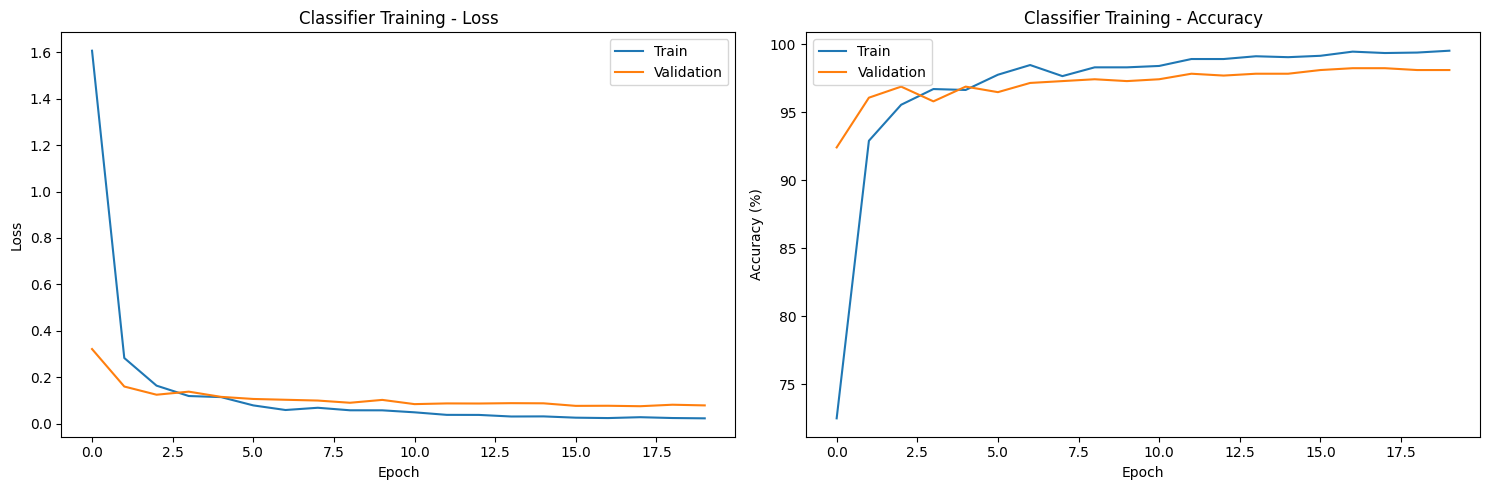

In [33]:
# Plot classifier training results
plot_training_history(classifier_history, "Classifier Training")

In [34]:
import pandas as pd
from torch.utils.data import DataLoader

# Configuration parameters
config = {
    'image_size': 224,
    'batch_size': 64,
    'num_workers': 2,
}

# Create transformations
transforms_dict = DataTransformations.create_transforms(config['image_size'])

# Create DataLoaders using the DataLoaderBuilder
loaders = DataLoaderBuilder.create_loaders(
    train_df=train_df,
    test_df=test_df,
    transforms_dict=transforms_dict,
    batch_size=config['batch_size'],
    mode='classifier'  # Specify mode as classifier for training
)

# Now you can access the test_loader from loaders
test_loader = loaders['test']

# You can print out some details about the test loader to verify it's set up correctly
print(f'Test Loader Size: {len(test_loader.dataset)}')


Dataset Label Validation [classifier]:
Number of samples: 2950
Label range: 0 - 20
Number of unique classes: 21
Samples per class - Min: 134, Max: 141, Mean: 140.48

Dataset Label Validation [classifier]:
Number of samples: 738
Label range: 0 - 20
Number of unique classes: 21
Samples per class - Min: 34, Max: 36, Mean: 35.14

Dataset Label Validation [classifier]:
Number of samples: 928
Label range: 0 - 20
Number of unique classes: 21
Samples per class - Min: 44, Max: 48, Mean: 44.19
Test Loader Size: 928


Test Loss: 0.0874, Test Accuracy: 97.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        48
           1       1.00      1.00      1.00        44
           2       0.96      1.00      0.98        44
           3       1.00      1.00      1.00        44
           4       1.00      0.98      0.99        44
           5       0.98      0.95      0.97        44
           6       1.00      1.00      1.00        44
           7       0.96      0.98      0.97        44
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        44
          10       0.98      1.00      0.99        44
          11       0.93      0.89      0.91        44
          12       0.97      0.86      0.92        44
          13       0.96      1.00      0.98        44
          14       1.00      1.00      1.00        44
          15       0.96      1.00      0.98        44
          16    

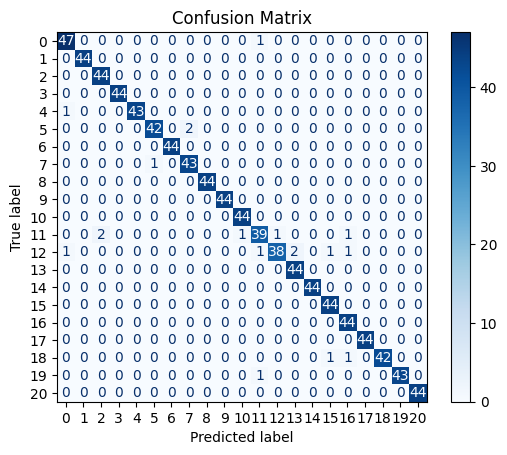

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import torch
import torch.nn.functional as F

model.eval()

# Initialize lists to collect true labels and predictions
true_labels = []
pred_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the test set
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append to lists for metrics
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate final test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = correct / total * 100
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))

# Confusion Matrix Visualization
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [36]:
def visualize_predictions(model, test_loader, device, num_images=5):
    """
    Visualize random test images with their predictions and actual labels
    """
    # Set model to eval mode
    model.eval()

    # Get a batch of images
    images, labels = next(iter(test_loader))

    # Get random indices
    total_images = len(images)
    indices = torch.randperm(total_images)[:num_images]

    # Create subplot
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

    with torch.no_grad():
        for idx, ax in enumerate(axes):
            # Get image and label
            image = images[indices[idx]].unsqueeze(0).to(device)
            true_label = labels[indices[idx]].item()

            # Get prediction
            outputs = model(image)
            pred_label = outputs.argmax(dim=1).item()

            # Denormalize image
            img_show = denormalize_image(images[indices[idx]])
            img_show = img_show.permute(1, 2, 0).numpy()

            # Plot
            ax.imshow(img_show)
            ax.axis('off')
            ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}',
                        color='green' if pred_label == true_label else 'red')

    plt.tight_layout()
    plt.show()

def denormalize_image(image):
    """
    Denormalize image tensor that was normalized with ImageNet stats
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    return image * std + mean

# Additional function to perform detailed evaluation
def detailed_evaluation(model, test_loader, device):
    """
    Perform detailed evaluation with confidence scores
    """
    model.eval()
    predictions = []
    true_labels = []
    confidences = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)

            # Get predictions and confidences
            probs = F.softmax(outputs, dim=1)
            conf, preds = probs.max(1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    confidences = np.array(confidences)

    print("\nDetailed Evaluation:")
    print(f"Average Confidence: {confidences.mean():.4f}")
    print(f"Min Confidence: {confidences.min():.4f}")
    print(f"Max Confidence: {confidences.max():.4f}")

    # Plot confidence distribution
    plt.figure(figsize=(10, 5))
    plt.hist(confidences, bins=50)
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.show()

    return predictions, true_labels, confidences

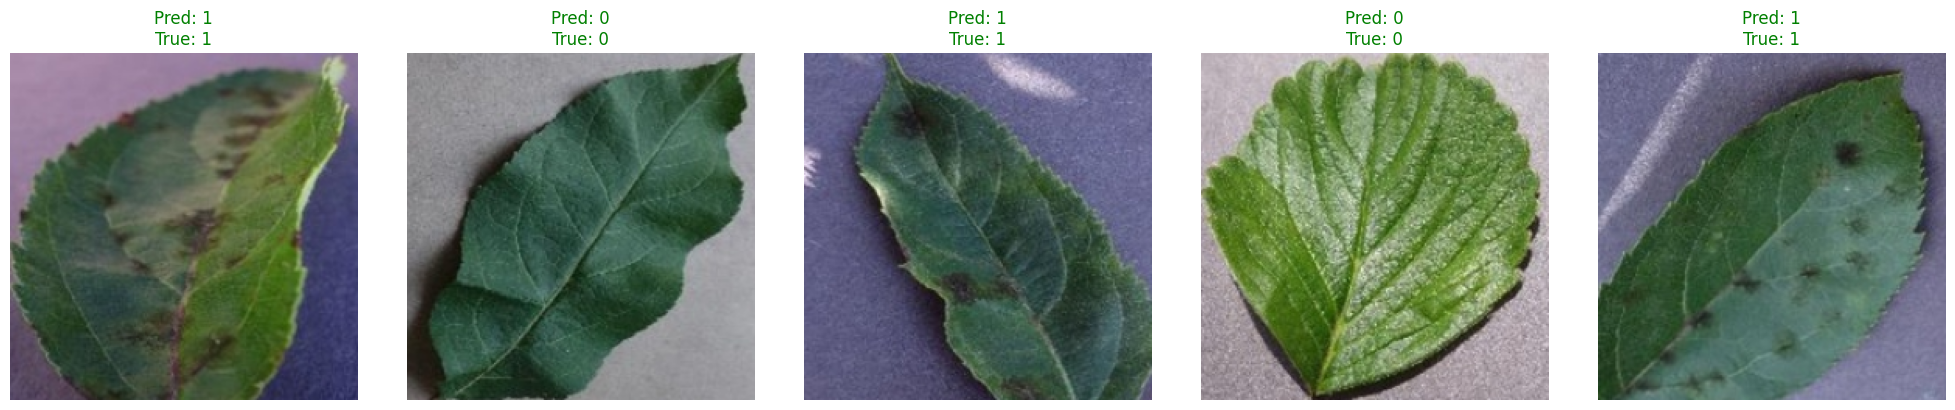


Detailed Evaluation:
Average Confidence: 0.9847
Min Confidence: 0.4004
Max Confidence: 1.0000


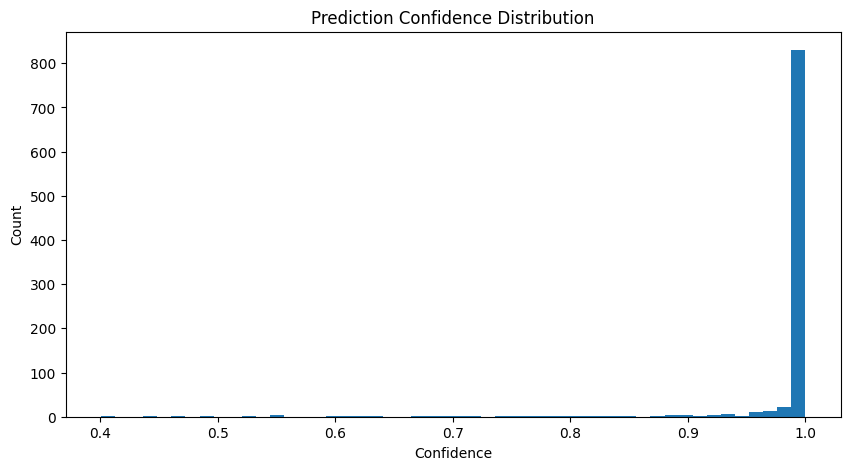

In [37]:
# Visualize random predictions
visualize_predictions(model, test_loader, device)

# Get detailed evaluation
predictions, true_labels, confidences = detailed_evaluation(model, test_loader, device)

In [38]:
def visualize_predictions_balanced(model, test_loader, device, samples_per_class=2):
    """
    Visualize test images with balanced class representation
    """
    model.eval()

    # Create dictionaries to store images and labels by class
    class_images = {}
    class_labels = {}

    # Collect images for each class
    with torch.no_grad():
        for images, labels in test_loader:
            for img, lbl in zip(images, labels):
                lbl_item = lbl.item()
                if lbl_item not in class_images:
                    class_images[lbl_item] = []
                    class_labels[lbl_item] = []
                if len(class_images[lbl_item]) < samples_per_class:
                    class_images[lbl_item].append(img)
                    class_labels[lbl_item].append(lbl_item)

                # Check if we have enough samples for all classes
                if all(len(imgs) >= samples_per_class for imgs in class_images.values()):
                    break

    # Calculate total number of images to display
    num_classes = len(class_images)
    total_images = num_classes * samples_per_class

    # Create subplot grid
    rows = (num_classes + 3) // 4  # Round up division to determine number of rows
    cols = min(4, num_classes)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    # Flatten axes for easier iteration
    axes_flat = axes.flatten()

    # Counter for positioning in subplot
    plot_idx = 0

    with torch.no_grad():
        # Iterate through each class
        for class_idx in sorted(class_images.keys()):
            for img in class_images[class_idx][:samples_per_class]:
                if plot_idx < len(axes_flat):
                    ax = axes_flat[plot_idx]

                    # Get prediction
                    image = img.unsqueeze(0).to(device)
                    outputs = model(image)
                    pred_label = outputs.argmax(dim=1).item()

                    # Denormalize image
                    img_show = denormalize_image(img)
                    img_show = img_show.permute(1, 2, 0).numpy()
                    img_show = np.clip(img_show, 0, 1)  # Clip values to valid range

                    # Plot
                    ax.imshow(img_show)
                    ax.axis('off')
                    ax.set_title(f'Pred: {pred_label}\nTrue: {class_idx}',
                               color='green' if pred_label == class_idx else 'red')

                    plot_idx += 1

    # Turn off any unused subplots
    for idx in range(plot_idx, len(axes_flat)):
        axes_flat[idx].axis('off')

    plt.tight_layout()
    plt.show()

def denormalize_image(image):
    """
    Denormalize image tensor that was normalized with ImageNet stats
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    return image * std + mean

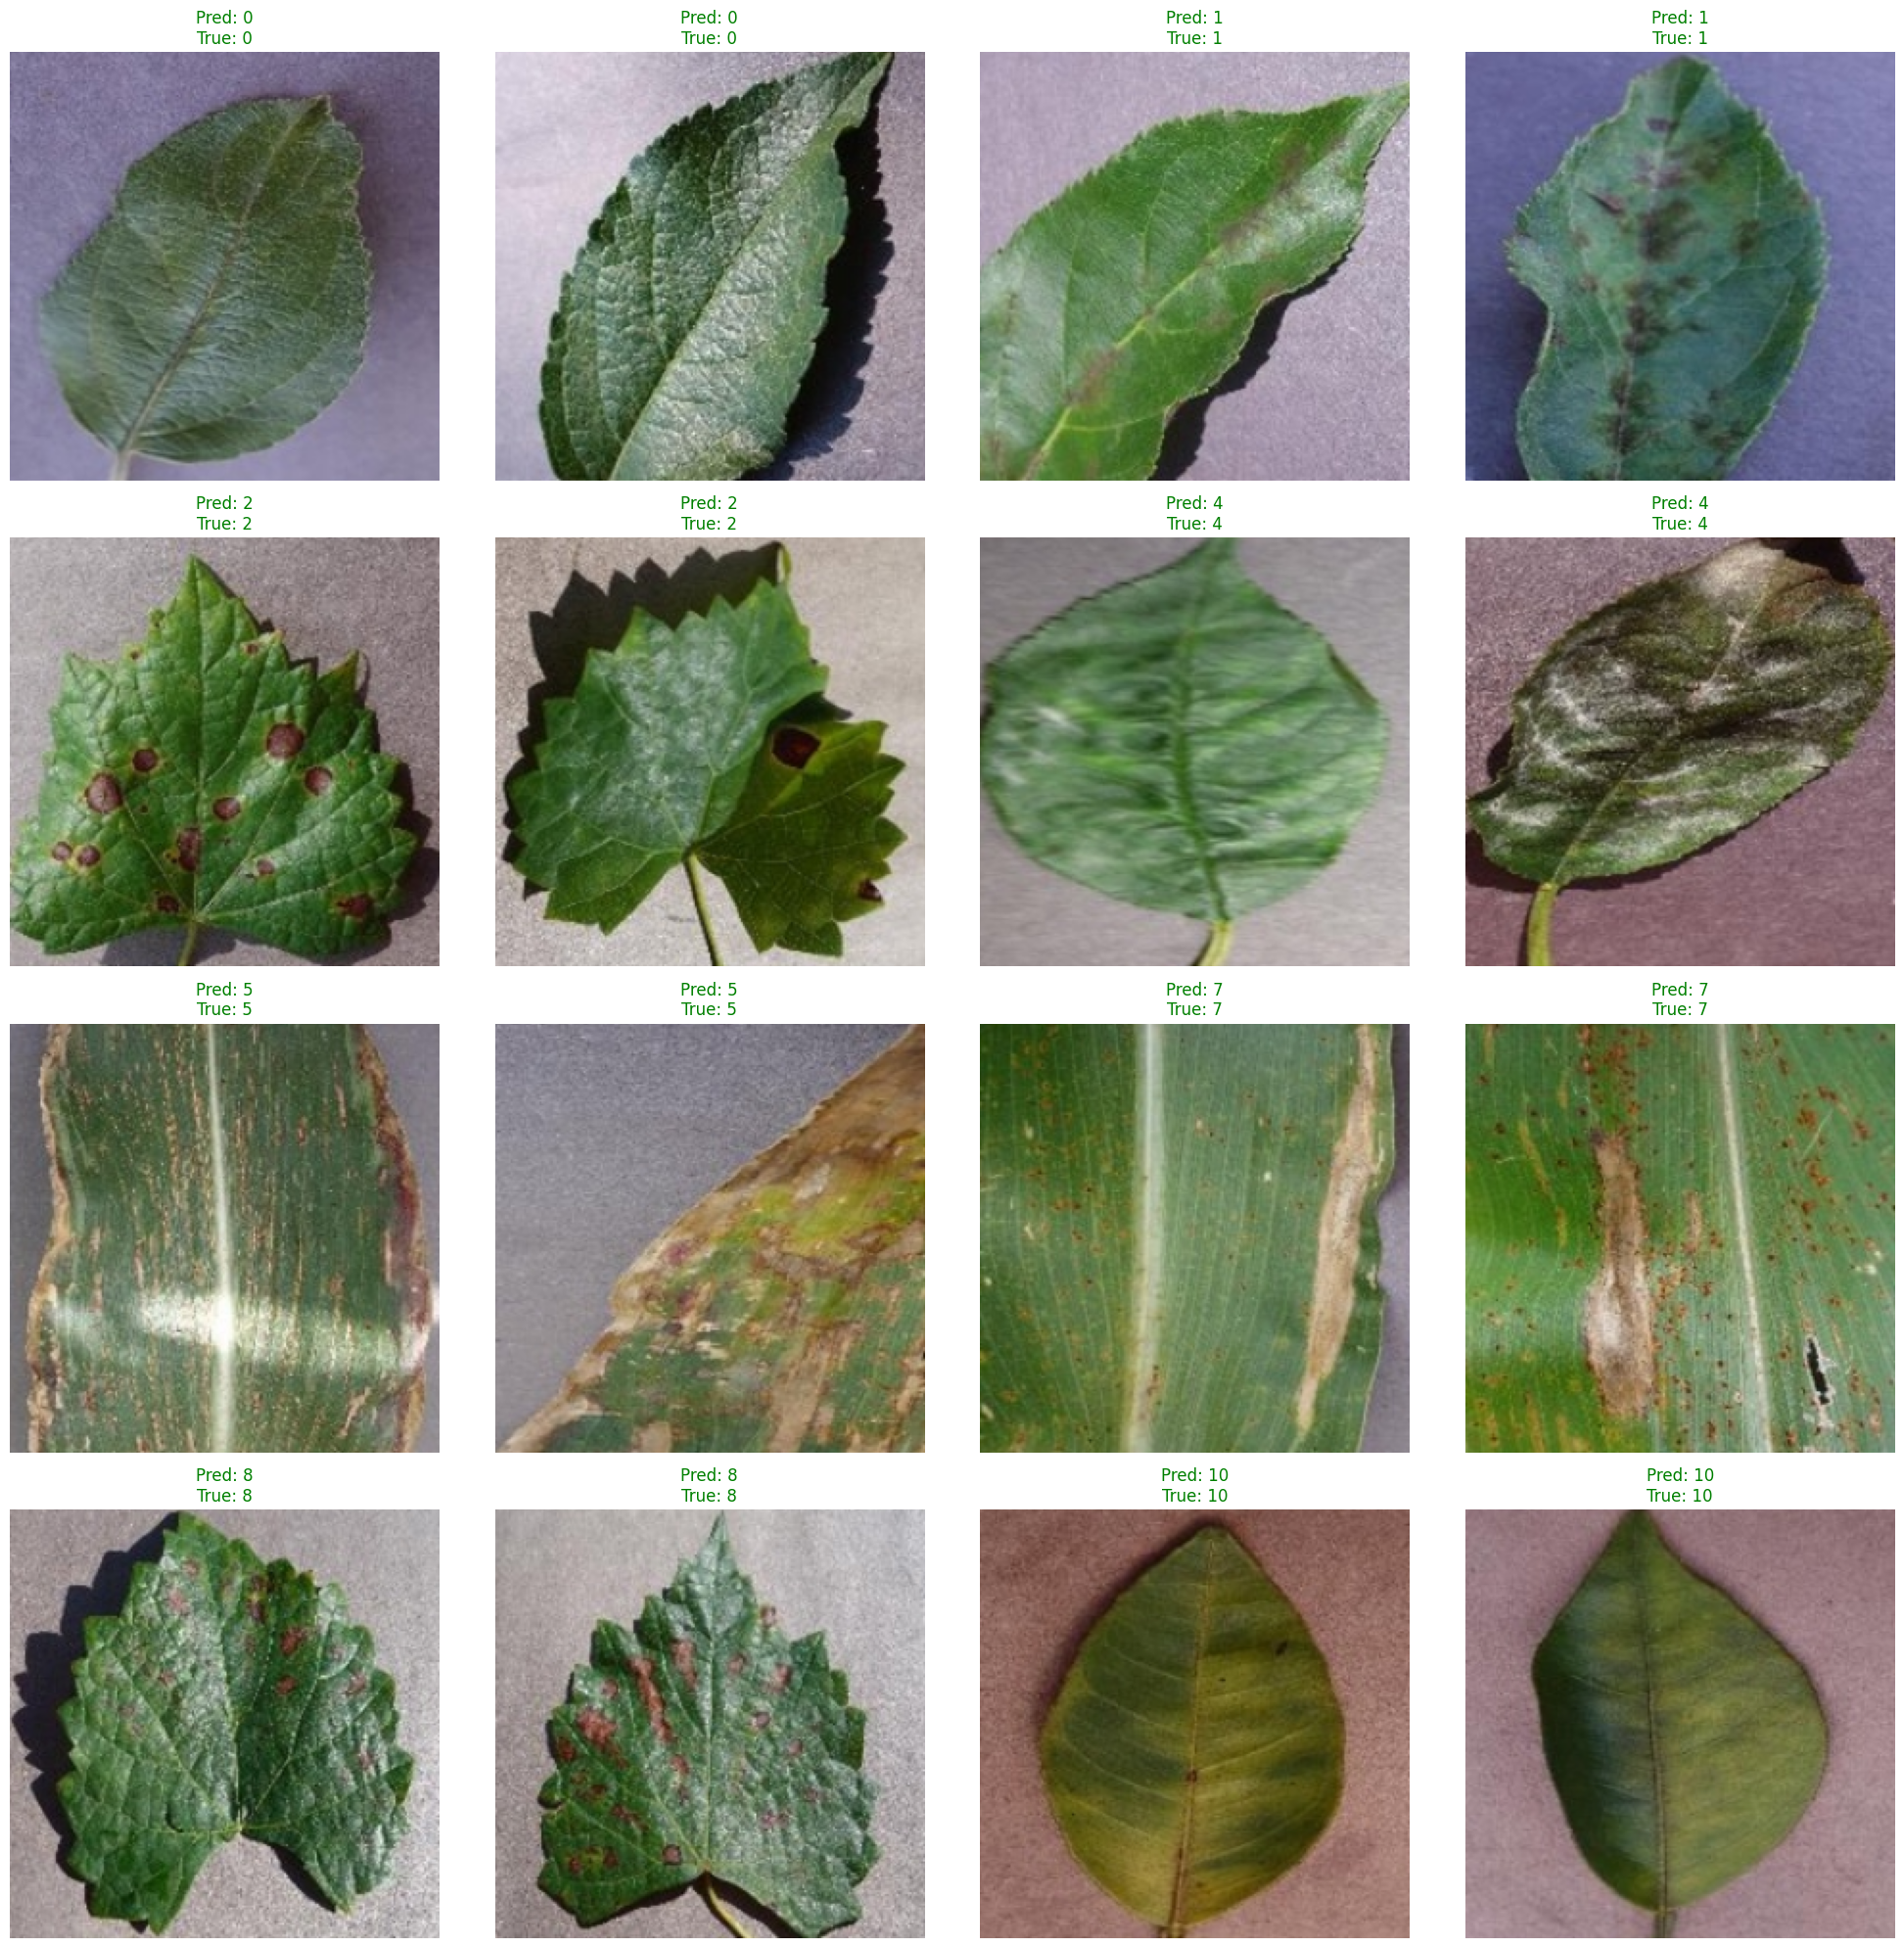

In [39]:
# Visualize predictions with 2 samples per class
visualize_predictions_balanced(model, test_loader, device, samples_per_class=2)

In [40]:
def predict_single_image(model, image_path, device):
    """
    Make prediction on a single image and visualize it

    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        device: torch.device
    """
    # Set model to evaluation mode
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')

    # Create transform pipeline similar to test transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Transform image
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = output.argmax(dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    # Prepare visualization
    plt.figure(figsize=(10, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot preprocessed image
    plt.subplot(1, 2, 2)
    processed_img = image_tensor.cpu().squeeze(0)
    processed_img = denormalize_image(processed_img)
    processed_img = processed_img.permute(1, 2, 0).numpy()
    processed_img = np.clip(processed_img, 0, 1)
    plt.imshow(processed_img)
    plt.title('Preprocessed Image')
    plt.axis('off')

    plt.suptitle(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2%}', y=1.05)
    plt.tight_layout()
    plt.show()

    print(f"\nPrediction Details:")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")

    # Print top-3 predictions
    top_probs, top_classes = torch.topk(probabilities, k=3)
    print("\nTop 3 Predictions:")
    for i, (prob, class_idx) in enumerate(zip(top_probs[0], top_classes[0])):
        print(f"Rank {i+1}: Class {class_idx.item()} with {prob.item():.2%} confidence")

    return predicted_class, confidence

def denormalize_image(image):
    """Denormalize image tensor that was normalized with ImageNet stats"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image * std + mean

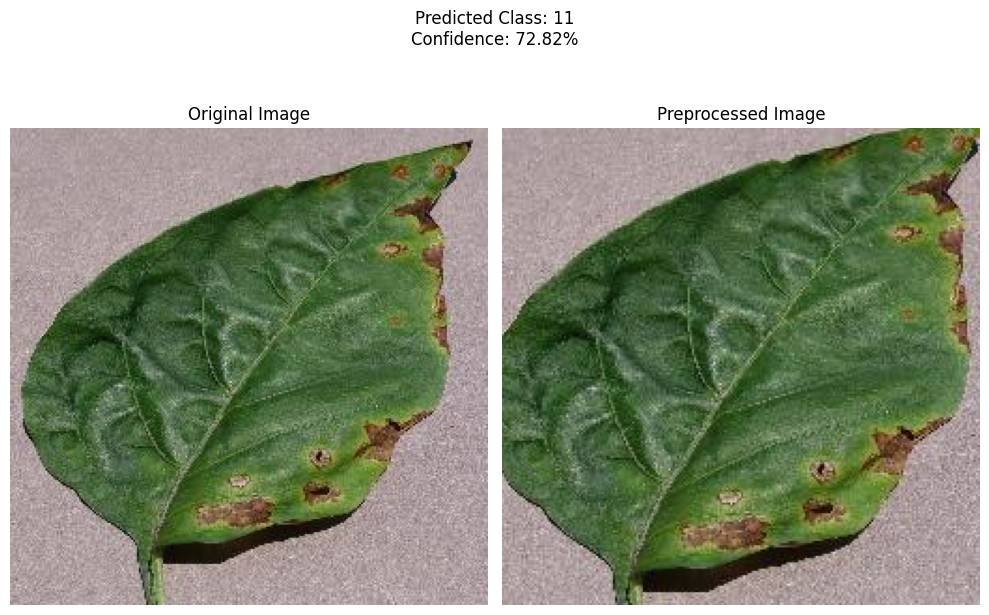


Prediction Details:
Predicted Class: 11
Confidence: 72.82%

Top 3 Predictions:
Rank 1: Class 11 with 72.82% confidence
Rank 2: Class 2 with 24.55% confidence
Rank 3: Class 18 with 0.88% confidence


In [52]:
# Path to your image
# image_path = "/content/drive/MyDrive/Test/3374a5c7-85b1-44a7-92a5-acf497aa3803___FAM_B.Msls-4347.JPG"
image_path = "/content/drive/MyDrive/Test/6820b823-5ed9-422d-ba0c-5134cd046588___JR_B.Spot-9049.JPG"


# Make prediction
predicted_class, confidence = predict_single_image(model, image_path, device)

In [42]:
def verify_data_separation(train_df, test_df):
    """Verify train and test set separation"""
    train_paths = set(train_df['full_path'].values)
    test_paths = set(test_df['full_path'].values)

    # Check for overlap
    overlap = train_paths.intersection(test_paths)
    if overlap:
        print(f"WARNING: Found {len(overlap)} overlapping images between train and test!")
        print("Sample overlapping paths:")
        for path in list(overlap)[:5]:
            print(path)
    else:
        print("No overlap found between train and test sets")

# Verify data separation
verify_data_separation(train_df, test_df)

No overlap found between train and test sets
